In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 500)

In [3]:
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'black',
                'ytick.color': 'black',
                'text.color': 'black'}
sns.set_style("darkgrid", rc=custom_style)

In [4]:
def barchart(data, x, y):
   sns.barplot(x = x,
               y = y,
               data = data)
   plt.show()

In [5]:
def piechart(data, values, labels):
    colors = sns.color_palette('pastel')[0:5]
    explode = [0.1, 0, 0, 0, 0, 0]
    plt.pie(data[values], labels=data[labels], colors=colors, explode=explode, autopct='%.0f%%')
    plt.show()
          

In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [7]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

In [8]:
stemmer = PorterStemmer()

In [9]:
def preprocess_review(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

## Classification in training dataset

In [10]:
train_df=pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv')
train_df.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,"This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read. For instance the intermixing of Chinese revolutionary history - how they kept accusing peo...",Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in December: http://www.audible.com/mt/ellison2?so...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I read it in 2 nights and couldn't put it down. The book is about the quantum theory of many worlds which states that all decisions we make throughout our lives basically create branches, and that each possible path through the decision tree can be thought of as a parallel world. And in this book, someone invents a way to switch between these worlds. This was nicely alluded to/foreshadowed in this quote: \n ""I think about all the choices we've made...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,"Recommended reading to understand what is going on in middle america, and possibly better explain why Trump won. http://www.npr.org/2016/11/09/5013826...",Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot to recommend it. It did drag on a little at the end so I knocked off 1 star - but overall a wow book. \n It's the story of a starship sent to Tau Ceti - the nearest star that has Earth analog planets - to colonize it. The journey there will take generations, and the story is told of the 3rd & 4th (?) generations, which are the ones that reaches Tau Ceti. It is a story of purpose, and how having a purpose affects behavior. A story of politics, an...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [11]:
train_df.dtypes

user_id         object
book_id          int64
review_id       object
rating           int64
review_text     object
date_added      object
date_updated    object
read_at         object
started_at      object
n_votes          int64
n_comments       int64
dtype: object

In [12]:
train_df.isnull().sum()

user_id              0
book_id              0
review_id            0
rating               0
review_text          0
date_added           0
date_updated         0
read_at          91766
started_at      274297
n_votes              0
n_comments           0
dtype: int64

<AxesSubplot:>

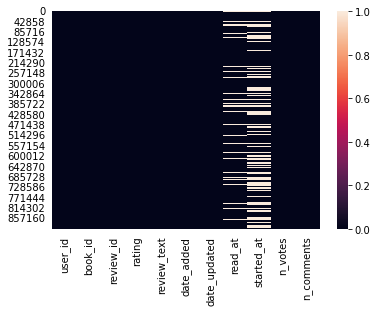

In [13]:
sns.heatmap(train_df.isnull())

In [14]:
r_bid=train_df.groupby('book_id').rating.mean().sort_values(ascending=False).reset_index().head(20)
r_bid.rename({'rating':'mean_rating'}, axis=1, inplace=True)
r_bid

,book_id,mean_rating
0,22844208,5.000000
1,11497913,5.000000
2,23456237,5.000000
3,14740811,5.000000
4,12997592,5.000000
5,16046507,5.000000
6,29810309,5.000000
7,35383830,5.000000
8,8442726,5.000000
9,25820867,5.000000


In [15]:
nr_users=train_df.rating.value_counts(normalize=True).reset_index()
nr_users.columns='rating rating_weight'.split()
nr_users

,rating,rating_weight
0,4,0.348542
1,5,0.294452
2,3,0.209969
3,2,0.080697
4,0,0.034431
5,1,0.031909


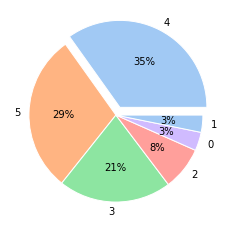

In [16]:
piechart(nr_users, 'rating_weight', 'rating')       

In [17]:
DATE_FORMAT = '%a %b %d %H:%M:%S %z %Y'

def parse_date(date_str):
    if (date_str != date_str) or (date_str is None):
        return None
    if len(date_str.split()) != 6:
        return None
    else:
        try:
            return datetime.strptime(date_str, DATE_FORMAT)
        except Exception as e:
            print(date_str, e)
        return None

In [18]:
from datetime import datetime
train_df['started_at_dt'] = train_df.started_at.apply(lambda x : parse_date(x))
train_df['read_at_dt'] = train_df.read_at.apply(lambda x : parse_date(x))
train_df['duration_dt'] = train_df.read_at_dt - train_df.started_at_dt

In [19]:
train_df.duration_dt=train_df.duration_dt.astype(str).apply(lambda x: 'nan' if 'nan' in x else(x[:x.find('days')] if 'days' in x else 0)).astype('float64')

In [20]:
train_df.duration_dt.fillna(train_df.duration_dt.mean(), inplace=True)

In [21]:
train_df2=train_df[train_df.duration_dt.isin(range(110))]
train_df2.shape

(606454, 14)

In [22]:
train_df2.groupby('rating').duration_dt.mean()

rating
0    7.943815
1    6.722896
2    6.891846
3    6.196238
4    5.557041
5    5.320184
Name: duration_dt, dtype: float64

In [23]:
rat_mean_days=train_df2.groupby('rating').duration_dt.mean().reset_index()
rat_mean_days.rename({'duration_dt':'mean_n_days_to_read'}, axis=1, inplace=True)
rat_mean_days

,rating,mean_n_days_to_read
0,0,7.943815
1,1,6.722896
2,2,6.891846
3,3,6.196238
4,4,5.557041
5,5,5.320184


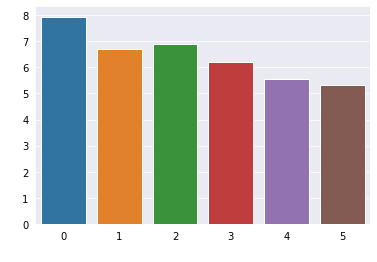

In [24]:
barchart(rat_mean_days, 'rating', 'mean_n_days_to_read')

In [25]:
train_df2['review_clean']=train_df2['review_text'].apply(preprocess_review)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
features='n_votes n_comments duration_dt review_clean rating'.split()
X=train_df2[features]
Y=X.pop('rating')

In [27]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.3, random_state=42)

In [28]:
from scipy import sparse

num_feats_train = X_train['n_votes n_comments duration_dt'.split()].values
num_feats_test = X_test['n_votes n_comments duration_dt'.split()].values

vectorizer = TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train.review_clean)
tf_x_test = vectorizer.transform(X_test.review_clean)

tf_x_train = sparse.hstack((tf_x_train, num_feats_train))
tf_x_test = sparse.hstack((tf_x_test, num_feats_test))

### 1. LinearSVC

In [29]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)

In [30]:
clf.fit(tf_x_train, Y_train)
y_pred = clf.predict(tf_x_test)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [31]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.07      0.12      2577
           1       0.40      0.25      0.30      4811
           2       0.40      0.23      0.29     14272
           3       0.45      0.37      0.41     38610
           4       0.49      0.55      0.52     65885
           5       0.58      0.67      0.62     55782

    accuracy                           0.51    181937
   macro avg       0.46      0.36      0.38    181937
weighted avg       0.50      0.51      0.50    181937



#### Finding best parameters for model using cross validation (not applied on first run)

In [32]:
# param_grid = {'clf__n_estimators': np.linspace(1, 100, 10, dtype=int),
#               'clf__min_samples_split': [3, 10],
#               'clf__min_samples_leaf': [3],
#               'clf__max_features': [7],
#               'clf__max_depth': [None],
#               'clf__criterion': ['gini'],
#               'clf__bootstrap': [False]}

In [33]:
# kfold = StratifiedKFold(n_splits=5)
# scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
# refit = 'F1'

In [34]:
# rf_model = GridSearchCV(clf, param_grid=param_grid, cv=kfold, scoring=scoring, 
#                          refit=refit, n_jobs=-1, return_train_score=True, verbose=1)
# rf_model.fit(X_train, Y_train)
# rf_best = rf_model.best_estimator_

### 2. Logistic Regression

In [35]:
clf2 = LogisticRegression(max_iter=1000,solver='saga')

In [36]:
pd.concat([pd.Series(Y_test).reset_index(drop=True), pd.Series(y_pred).rename('predicted_rating').reset_index(drop=True)], axis=1)

,rating,predicted_rating
0,4,4
1,5,5
2,2,3
3,2,5
4,5,5
...,...,...
181932,4,5
181933,2,3
181934,3,3
181935,3,5


In [37]:
clf2.fit(tf_x_train, Y_train)
y_pred = clf2.predict(tf_x_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [38]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2577
           1       0.00      0.00      0.00      4811
           2       0.00      0.00      0.00     14272
           3       0.00      0.00      0.00     38610
           4       0.37      0.95      0.54     65885
           5       0.66      0.17      0.27     55782

    accuracy                           0.40    181937
   macro avg       0.17      0.19      0.13    181937
weighted avg       0.34      0.40      0.28    181937



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification on test set

In [39]:
test_df=pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv')
test_df.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,b9450d1c1f97f891c392b1105959b56e,7092507,5c4df7e70e9b438c761f07a4620ccb7c,"** spoiler alert ** \n This is definitely one of my favorites among the ""food books"" I've read! I loved the characters (Raggedy Ann and Ken Carson included)! Even though Kayla is a pessimist (which I usually dislike in a character), her personality is the perfect formula in the story. \n Kayla is the school rebel, she wears unusual clothes, makes fun of the ""popular"" crowd in school, and she only have one friend in school---Nicole. Lately, things have been changing around her. Her mother bar...",Sat Nov 10 06:06:13 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sat Nov 10 00:00:00 -0800 2012,1,0
1,b9450d1c1f97f891c392b1105959b56e,5576654,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink."" \n I'm a huge fan of coffee but I don't buy my coffee in Starbucks or other coffee shops because I find it expensive. If you drink too much coffee like I do, it's economical to make it myself. LOL. So, I'm not very familiar with the kind of coffee and lattes being mentioned in the book. However, I find Jane's match making skills amusing. It sound unreal but interesting nonetheless. \n Jane Turner is a teenage employee of Wired Joe's coffee sho...",Fri Nov 09 21:55:16 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,1,0
2,b9450d1c1f97f891c392b1105959b56e,15754052,dce649b733c153ba5363a0413cac988f,"Roar is one of my favorite characters in Under the Never Sky and I'm so happy to read his story. Roar is usually the happy and out going kind of guy but in this book we see his serious side. This novella left me wanting for more! I felt so bad for Liv and Roar...I hate Vale! How could he sell his own sister?!? Anyway, I hope Roar finds Liv in the next book!",Fri Nov 09 00:25:50 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,0,0
3,b9450d1c1f97f891c392b1105959b56e,17020,8a46df0bb997269d6834f9437a4b0a77,"** spoiler alert ** \n If you feel like travelling to Europe and you don't have the money for it, read this book and you'll experience the beauty and madness of Europe! \n When I read Aunt Peg's first envelope, I thought this is just a simple adventure she made up for Ginny. I thought she just want Ginny to loosen up a bit and try to have fun. However, as I continue reading her little blue envelopes, I realized that Aunt Peg want Ginny to get something more than just fun on her Europe escapa...",Thu Nov 01 00:28:39 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Thu Nov 01 00:00:00 -0700 2012,0,0
4,b9450d1c1f97f891c392b1105959b56e,12551082,d11d3091e22f1cf3cb865598de197599,"3.5 stars \n I read and enjoyed the first two novels from this series and I have to say that in this book I miss the ""sporty"" part of this supposedly sports contemporary novel. Anyhow, I still liked it and there were a lot of lessons pertaining to faith and religious belief. I have nothing against Christian novels, I read them occasionally and enjoy them most of the time. On this particular novel though, you have to understand that the heroine is a teenager and is in a process of finding her...",Thu Oct 18 00:57:00 -0700 2012,Mon Apr 01 23:00:51 -0700 2013,Sat Mar 30 00:00:00 -0700 2013,Fri Mar 29 00:00:00 -0700 2013,0,0


In [40]:
test_df.isnull().sum()

user_id              0
book_id              0
review_id            0
review_text          0
date_added           0
date_updated         0
read_at          42478
started_at      143044
n_votes              0
n_comments           0
dtype: int64

In [41]:
from datetime import datetime
test_df['started_at_dt'] = test_df.started_at.apply(lambda x : parse_date(x))
test_df['read_at_dt'] = test_df.read_at.apply(lambda x : parse_date(x))
test_df['duration_dt'] = test_df.read_at_dt - test_df.started_at_dt

In [42]:
test_df.duration_dt=test_df.duration_dt.astype(str).apply(lambda x: 'nan' if 'nan' in x else(x[:x.find('days')] if 'days' in x else 0)).astype('float64')

In [43]:
test_df.duration_dt.fillna(test_df.duration_dt.mean(), inplace=True)

In [44]:
test_df['review_clean']=test_df['review_text'].apply(preprocess_review)

In [45]:
test_df.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,started_at_dt,read_at_dt,duration_dt,review_clean
0,b9450d1c1f97f891c392b1105959b56e,7092507,5c4df7e70e9b438c761f07a4620ccb7c,"** spoiler alert ** \n This is definitely one of my favorites among the ""food books"" I've read! I loved the characters (Raggedy Ann and Ken Carson included)! Even though Kayla is a pessimist (which I usually dislike in a character), her personality is the perfect formula in the story. \n Kayla is the school rebel, she wears unusual clothes, makes fun of the ""popular"" crowd in school, and she only have one friend in school---Nicole. Lately, things have been changing around her. Her mother bar...",Sat Nov 10 06:06:13 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sat Nov 10 00:00:00 -0800 2012,1,0,2012-11-10 00:00:00-08:00,2012-11-11 05:38:36-08:00,0.0,"** spoiler alert ** definit one favorit among ""food books"" i'v read! love charact (raggedi ann ken carson included)! even though kayla pessimist (which usual dislik character), person perfect formula story. kayla school rebel, wear unusu clothes, make fun ""popular"" crowd school, one friend school---nicole. lately, thing chang around her. mother bare talk best friend date long-tim crush ben! disastr birthday party, made wish make birthday wish come true. follow day wake pink poni backyard!..."
1,b9450d1c1f97f891c392b1105959b56e,5576654,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink."" \n I'm a huge fan of coffee but I don't buy my coffee in Starbucks or other coffee shops because I find it expensive. If you drink too much coffee like I do, it's economical to make it myself. LOL. So, I'm not very familiar with the kind of coffee and lattes being mentioned in the book. However, I find Jane's match making skills amusing. It sound unreal but interesting nonetheless. \n Jane Turner is a teenage employee of Wired Joe's coffee sho...",Fri Nov 09 21:55:16 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,1,0,2012-11-09 00:00:00-08:00,2012-11-10 05:41:49-08:00,0.0,"** spoiler alert ** ""you drink."" i'm huge fan coffe buy coffe starbuck coffe shop find expensive. drink much coffe like do, econom make myself. lol. so, i'm familiar kind coffe latt mention book. however, find jane' match make skill amusing. sound unreal interest nonetheless. jane turner teenag employe wire joe' coffe shop. work barista predict customer' order look them. keep notebook write observations. one day, one favorit regular broke girlfriend jane got idea set co-worker' friend. fi..."
2,b9450d1c1f97f891c392b1105959b56e,15754052,dce649b733c153ba5363a0413cac988f,"Roar is one of my favorite characters in Under the Never Sky and I'm so happy to read his story. Roar is usually the happy and out going kind of guy but in this book we see his serious side. This novella left me wanting for more! I felt so bad for Liv and Roar...I hate Vale! How could he sell his own sister?!? Anyway, I hope Roar finds Liv in the next book!",Fri Nov 09 00:25:50 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,0,0,2012-11-09 00:00:00-08:00,2012-11-10 06:14:10-08:00,0.0,"roar one favorit charact never sky i'm happi read story. roar usual happi go kind guy book see seriou side. novella left want more! felt bad liv roar...i hate vale! could sell sister?!? anyway, hope roar find liv next book!"
3,b9450d1c1f97f891c392b1105959b56e,17020,8a46df0bb997269d6834f9437a4b0a77,"** spoiler alert ** \n If you feel like travelling to Europe and you don't have the money for it, read this book and you'll experience the beauty and madness of Europe! \n When I read Aunt Peg's first envelope, I thought this is just a simple adventure she made up for Ginny. I thought she just want Ginny to loosen up a bit and try to have fun. However, as I continue reading her little blu

In [46]:
test_review_vect=vectorizer.transform(test_df.review_clean)

In [47]:
test_num_feats=test_df['n_votes n_comments duration_dt'.split()].values

In [48]:
test_input=sparse.hstack((test_review_vect, test_num_feats))

In [49]:
test_df['rating']=clf.predict(test_input)

In [50]:
test_df['review_id rating'.split()].to_csv(r'goodreads_submission.csv', index=False)